In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import math
#import lib.lib_tf as lt
import matplotlib.pyplot as plt


#lt.init_gpu()


def plot_samples(data,
                 n=5,
                 max_cols=5,
                 cmap="tab20"
                 ):
    n = min(len(data), n)
    if n < max_cols:
        rows = 1
        cols = n
    else:
        rows = math.ceil(n / max_cols)
        cols = max_cols
    print(f"rows: {rows}, cols: {cols}")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True, figsize=(20, 10))
    #ax = ax.flatten()
    index = 0
    for i in range(rows):
        for j in range(cols):
            img = data[index]
            index += 1
            #    .numpy().reshape(X.shape[1],X.shape[2],2)
            print()
            ax[i, j].imshow(img, cmap=cmap, interpolation='nearest')
            if index >= n:
                break

    #ax[0].set_xticks([])
    #ax[0].set_yticks([])
    plt.tight_layout()
    # plt.savefig('./figures/mnist_all.png', dpi=300)
    plt.show()

In [4]:
(mnist_images, mnist_labels), (mnist_images_test, mnist_labels_test) = tf.keras.datasets.mnist.load_data()

X_train = tf.cast(mnist_images[..., tf.newaxis] / 255, tf.float32)
y_train = tf.cast(mnist_labels, tf.int64)

X_test = tf.cast(mnist_images_test[..., tf.newaxis] / 255, tf.float32)
y_test = tf.cast(mnist_labels_test, tf.int64)

num_category = 10

y_train_v = tf.keras.utils.to_categorical(y_train, num_category)
y_test_v = tf.keras.utils.to_categorical(y_test, num_category)

dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(mnist_images[..., tf.newaxis] / 255, tf.float32),
         tf.cast(mnist_labels, tf.int64))
        )
batch_size = 128
dataset = dataset.shuffle(1000).batch(batch_size)

dataset_test = tf.data.Dataset.from_tensor_slices(
        (X_test, y_test)
        )
dataset_test = dataset_test.shuffle(1000).batch(batch_size)

x_train, x_test = mnist_images / 255.0, mnist_images_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
batch = 128
train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)
        ).shuffle(10000).batch(batch_size=batch)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


2025-03-31 17:28:41.143294: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-03-31 17:28:41.143332: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-03-31 17:28:41.143338: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
I0000 00:00:1743434921.143353 1580750 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743434921.143376 1580750 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
mnist_images.shape

(60000, 28, 28)

rows: 4, cols: 5






















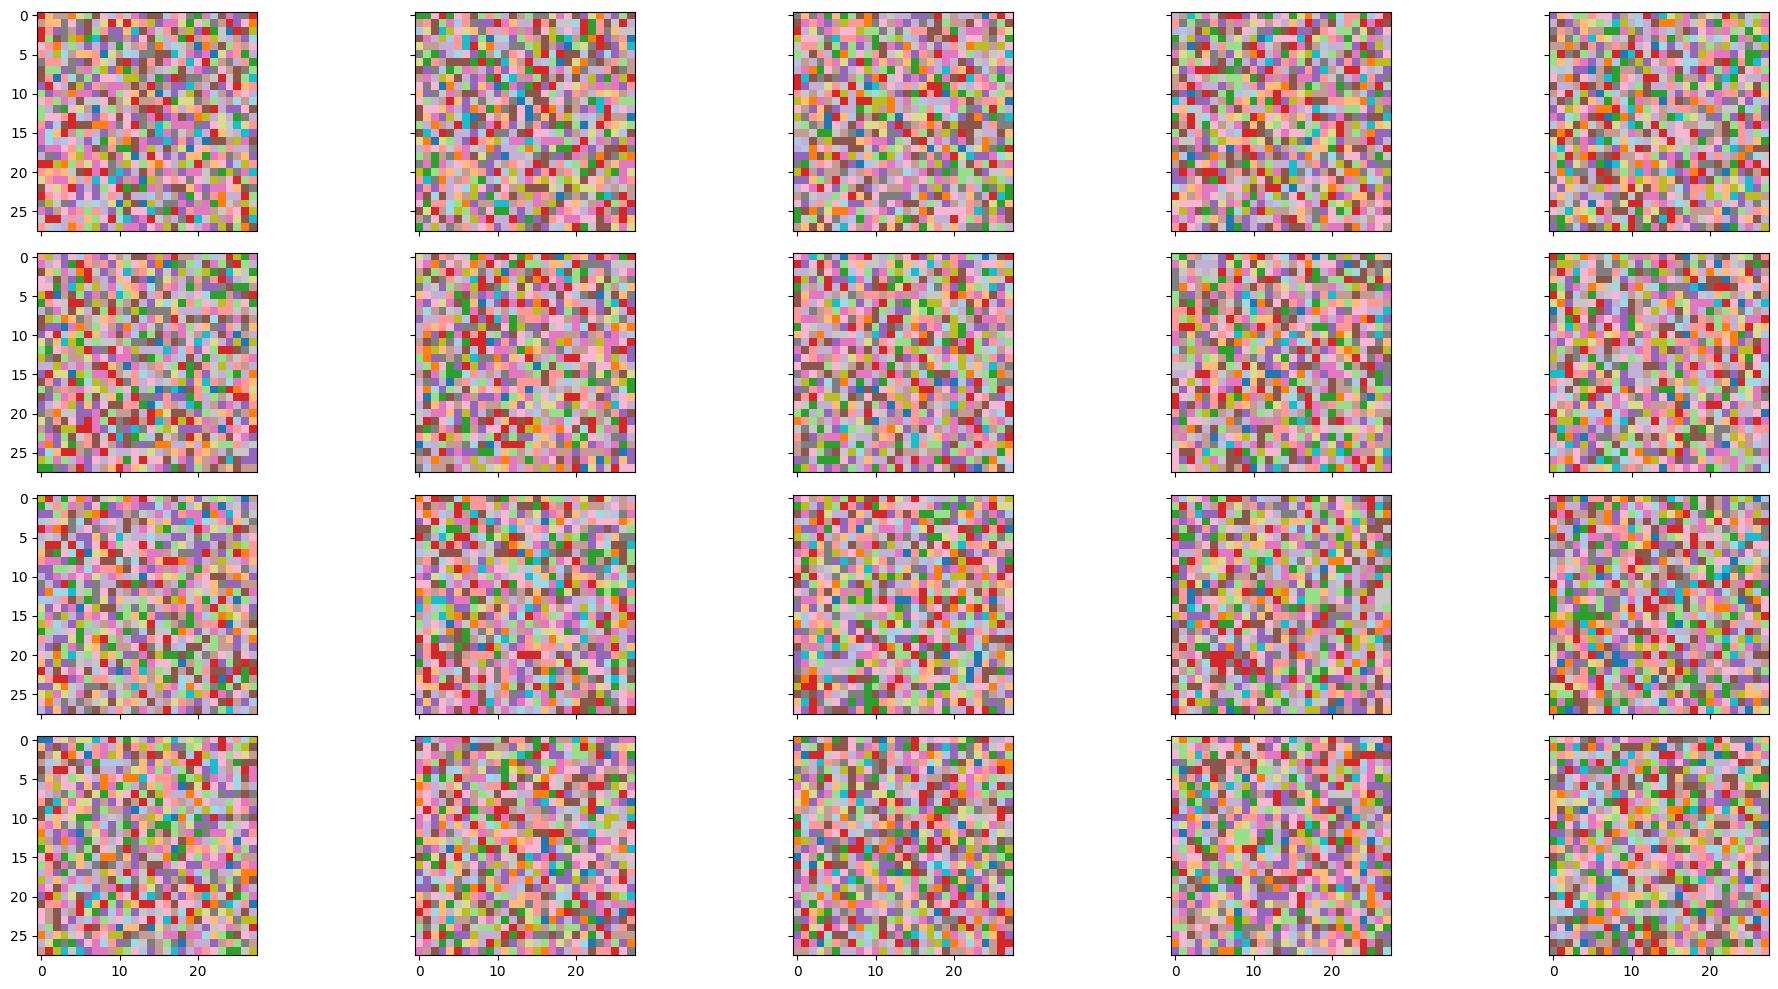

In [7]:
base_model = tf.keras.Sequential(
        [
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal'),
                tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='he_normal')
                ]
        )
base_model.build(input_shape=(None, 28, 28, 1))
opti = tf.keras.optimizers.SGD(
        learning_rate=0.02, momentum=0.00,
        nesterov=False, name='SGD'
        )
opti2 = tf.keras.optimizers.Adadelta()
opti3 = tf.keras.optimizers.Adam()
# base_model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=opti,
#               metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy', min_delta=0.002, patience=2, mode='auto', verbose=True,
        restore_best_weights=True
        )

base_model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=opti,
        metrics=['accuracy']
        )

layer = base_model.layers[1].get_weights()[0]
images = [np.reshape(layer[:, i], (28, 28)) for i in range(20)]
plot_samples(images, n=20)
#base_model.build(input_shape=(None,28,28,1))

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9160 - loss: 0.3051
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9164 - loss: 0.3036
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9171 - loss: 0.3025
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
rows: 4, cols: 5






















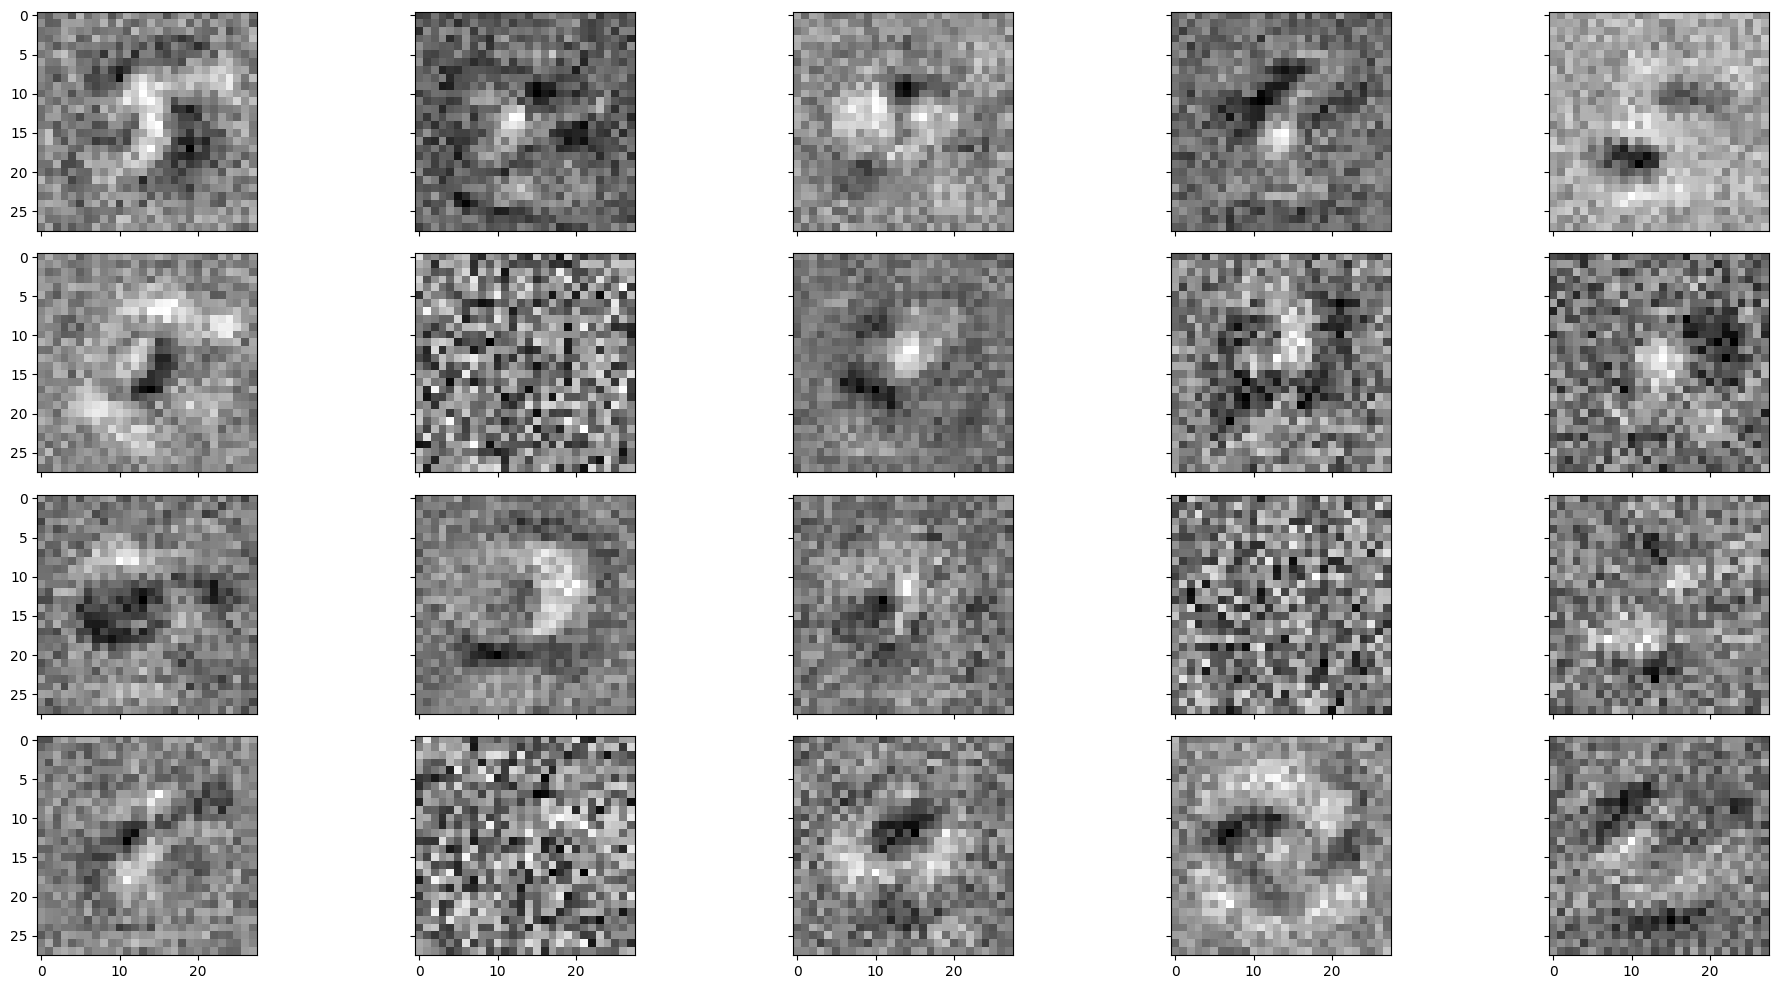

In [10]:
arly_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',  # Monitor validation loss
        patience=3,  # Stop after 3 epochs with no improvement
        verbose=1,  # Print stopping info
        min_delta=0.001,  # Minimum change in loss
        restore_best_weights=True  # Restore weights from the best epoch
        )
base_model.fit(dataset, epochs=15, callbacks=[early_stopping])
# lt.eval_model(
#         base_model, X_train, y_train, X_test, y_test,
#         epochs=20, batch_size=64, callbacks=[early_stopping]
#         )
layer_1_weights = base_model.layers[1].get_weights()[0].copy()
layer = base_model.layers[1].get_weights()[0]
imgages = [np.reshape(layer[:, i], (28, 28)) for i in range(20)]
plot_samples(imgages, n=20, cmap="grey")

rows: 4, cols: 5






















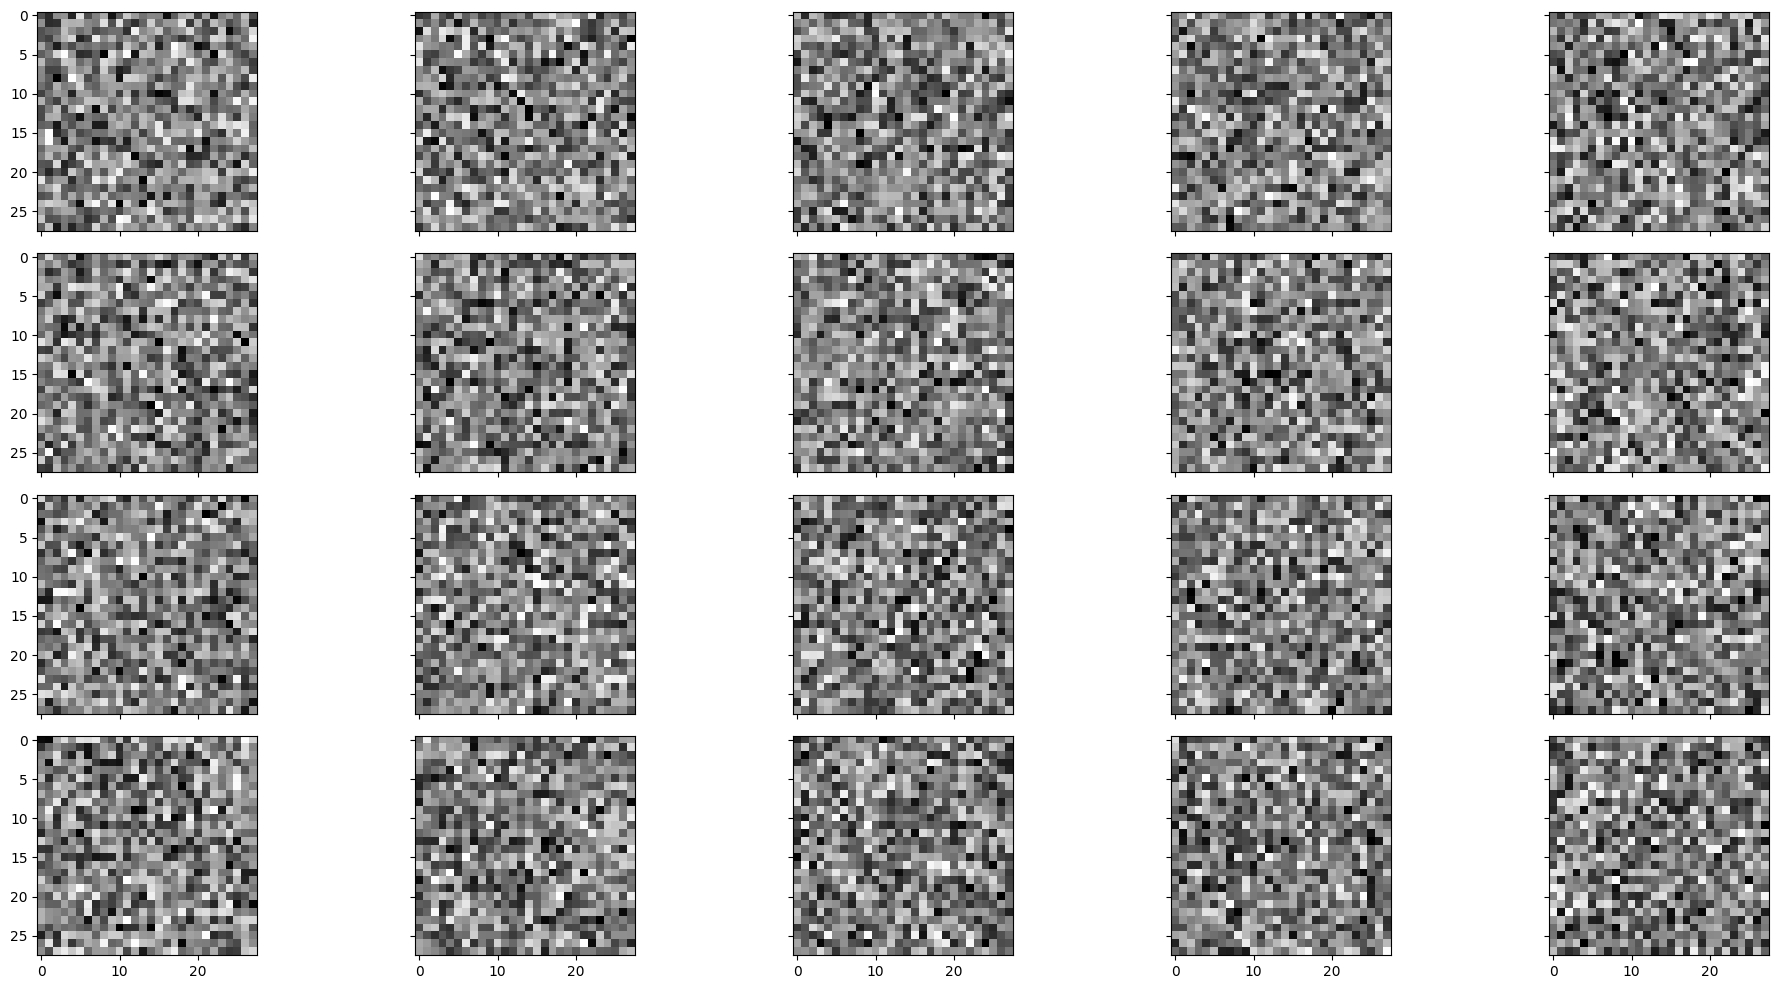

In [11]:
plot_samples(images, n=20, cmap="grey")

In [194]:

base_model.evaluate(X_test, y_test, verbose=0)

[0.284691721200943, 0.9212999939918518]

In [188]:
abaltion_weights.shape

(784, 20)

In [199]:
abaltion_weights = layer_1_weights.copy()
abaltion_weights[:, 6] = 0
abaltion_weights[:, 14] = 0
base_model.layers[1].set_weights([abaltion_weights, base_model.layers[1].get_weights()[1]])
# print(base_model.layers[1].get_weights()[0][:, 0])
base_model.evaluate(X_test, y_test, verbose=0)

[0.29350996017456055, 0.9189000129699707]

rows: 4, cols: 5






















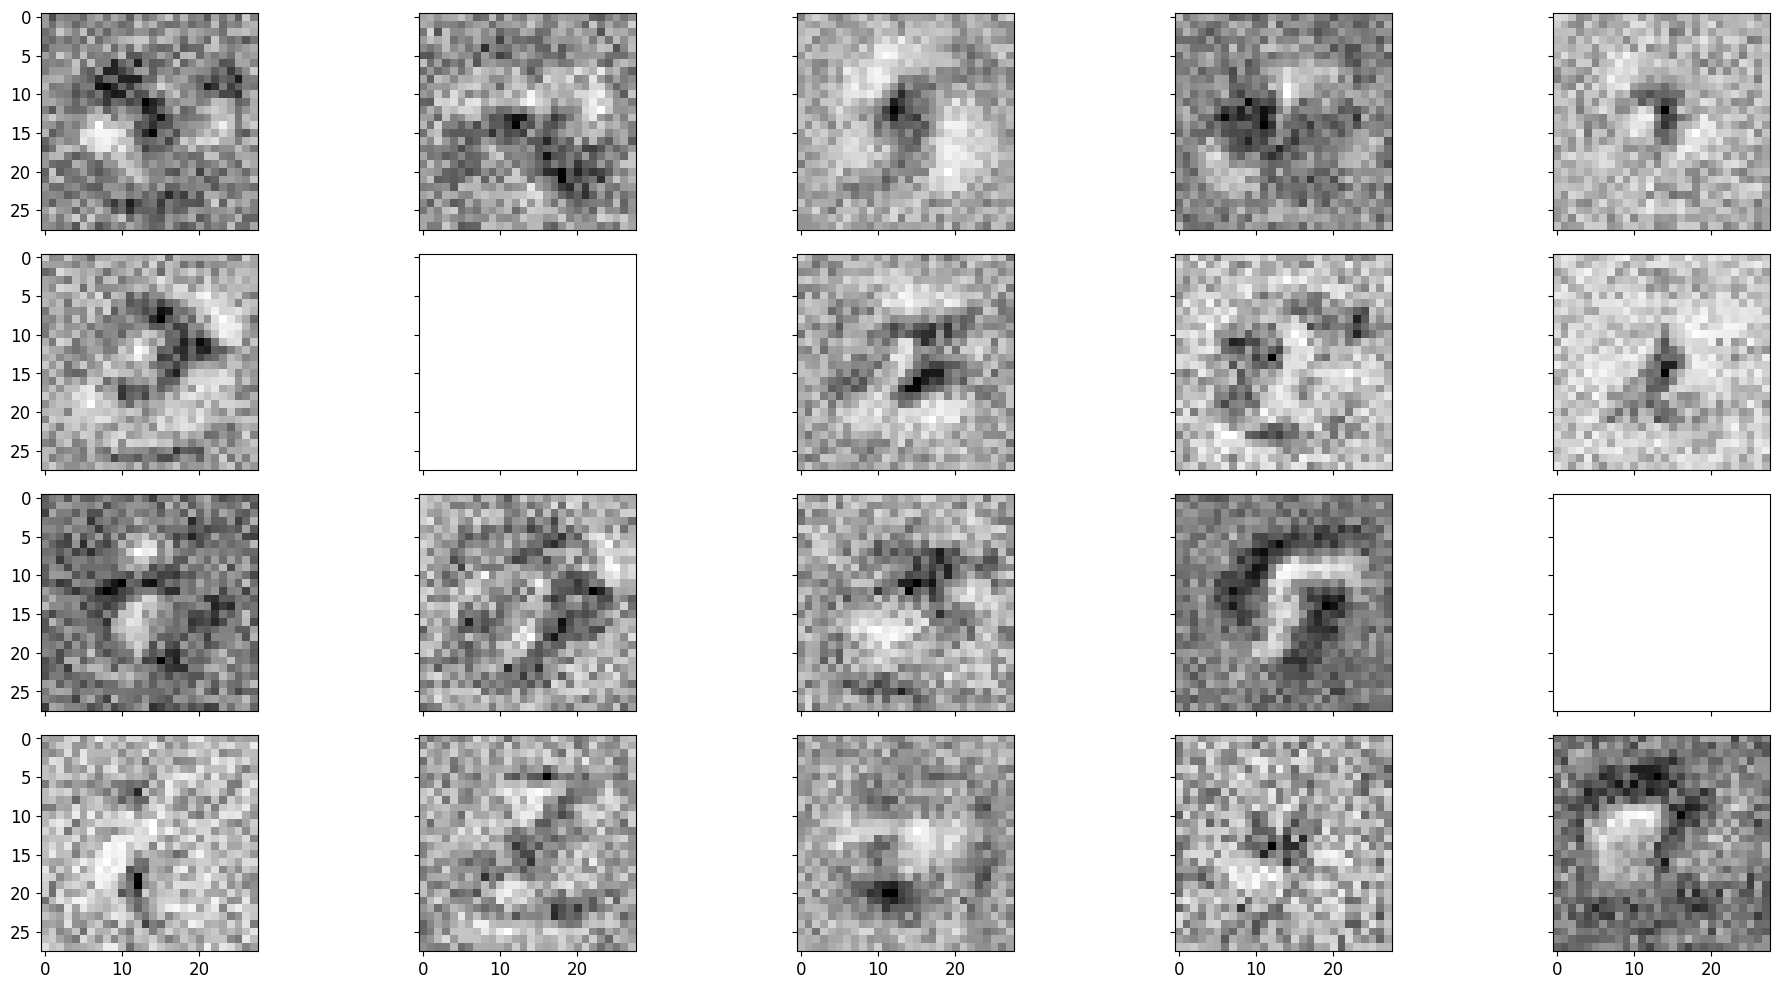

In [200]:
layer = base_model.layers[1].get_weights()[0]
imgages = [np.reshape(layer[:, i], (28, 28)) for i in range(20)]
plot_samples(imgages, n=20)

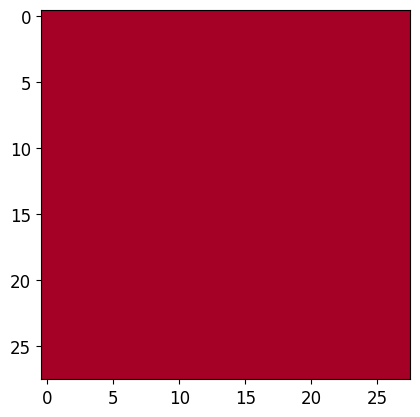

In [202]:
img = np.reshape(layer[:, 6], (28, 28))
plt.imshow(img, cmap='RdYlBu', interpolation='nearest')

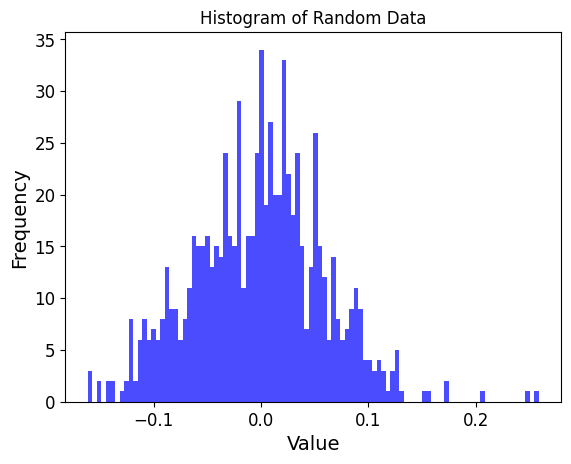

In [210]:
#unit_weights = base_model.layers[1].get_weights()[0][:,5]
unit_weights = layer_1_weights[:, 15]
img = np.reshape(unit_weights, (28, 28))
data = img.flatten()
plt.hist(data, bins=100, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Random Data')
plt.show()


rows: 4, cols: 5






















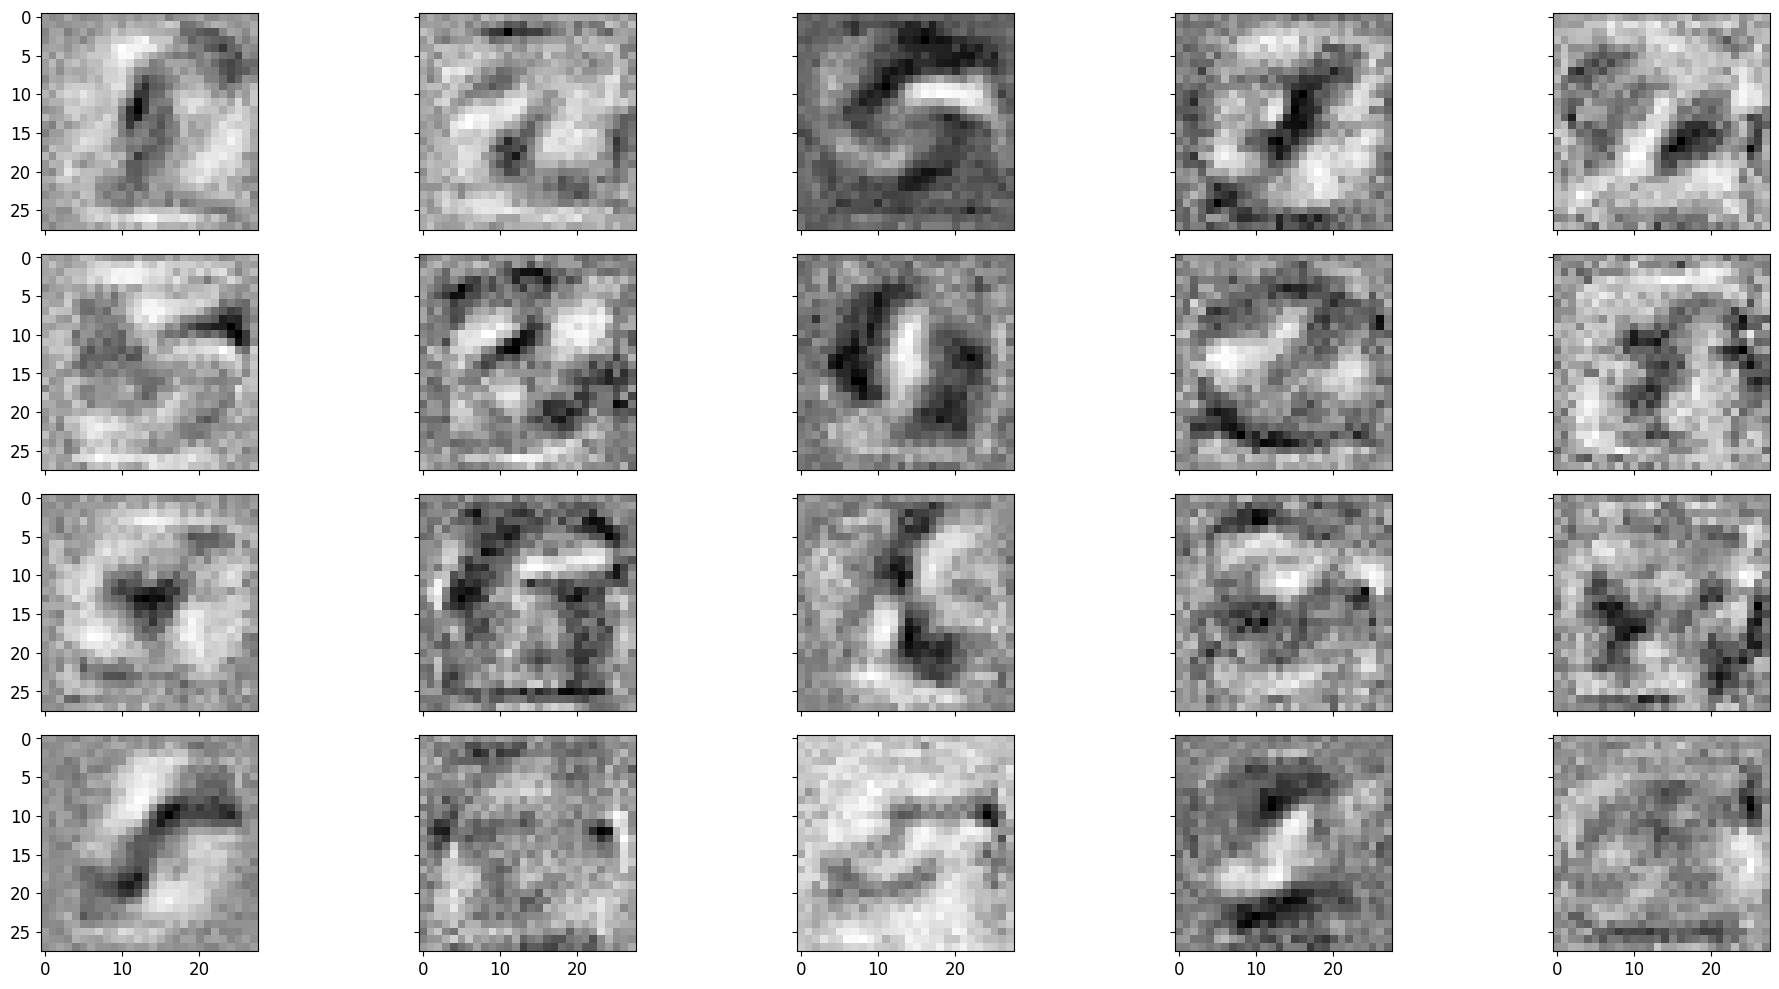

In [118]:
imgages = [np.reshape(layer[:, i], (28, 28)) for i in range(20)]
plot_samples(imgages, n=20)

In [53]:
m1 = tf.keras.Sequential(
        name="2D-Conv", layers=[
                tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], activation='relu', input_shape=(28, 28, 1)),
                #    tf.keras.layers.Conv2D(filters=32,kernel_size=[3,3], activation='relu'),
                #    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                #    tf.keras.layers.Dropout(0.25),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
                ]
        )
m1.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=opti3,
        metrics=['accuracy']
        )
lt.eval_model(m1, X_train, y_train, X_test, y_test, epochs=12, batch_size=128)

models 2D-Conv, batch_size = 128
Epoch 1/12
469/469 [==============================] - 2s 4ms/step - loss: 0.2042 - accuracy: 0.9403
Epoch 2/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0892 - accuracy: 0.9743
Epoch 3/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0724 - accuracy: 0.9783
Epoch 4/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0631 - accuracy: 0.9819
Epoch 5/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0653 - accuracy: 0.9811
Epoch 6/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0607 - accuracy: 0.9828
Epoch 7/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0634 - accuracy: 0.9823
Epoch 8/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0658 - accuracy: 0.9821
Epoch 9/12
469/469 [==============================] - 2s 4ms/step - loss: 0.0733 - accuracy: 0.9807
Epoch 10/12
469/469 [==============================] - 2s 4ms/step 

(<keras.src.callbacks.History at 0x3333ae090>,
 [0.19414448738098145, 0.9710000157356262])

In [54]:
img = X_train[0:1, :, :, :]
print(img.shape)
m1(img)

(1, 28, 28, 1)


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[3.5911399e-36, 5.7165161e-13, 1.7933525e-31, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 3.3217287e-37, 0.0000000e+00,
        6.0917880e-38, 0.0000000e+00]], dtype=float32)>

(1, 26, 26, 16)
rows: 4, cols: 5


















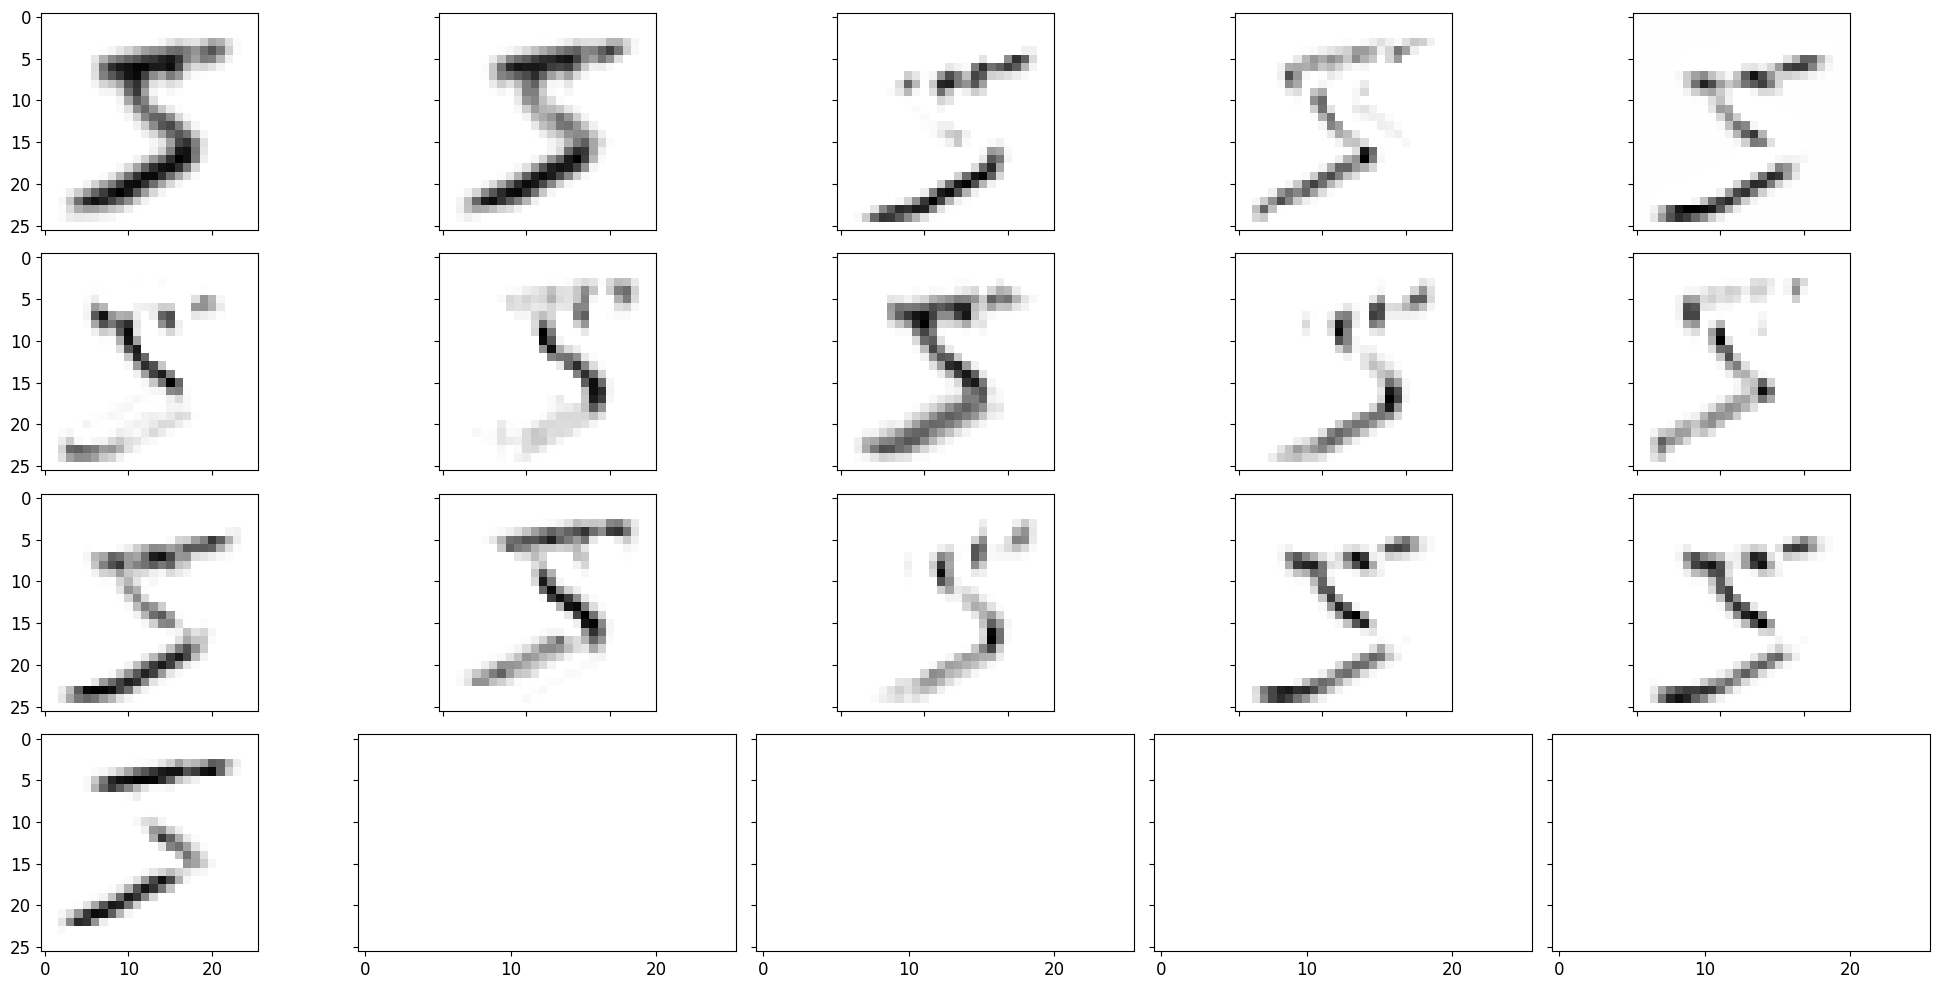

In [72]:
conv = m1.layers[0](img)
print(conv.shape)


def plot_samples(data,
                 n=5,
                 max_cols=5
                 ):
    n = min(len(data), n)
    if n < max_cols:
        rows = 1
        cols = n
    else:
        rows = math.ceil(n / max_cols)
        cols = max_cols
    print(f"rows: {rows}, cols: {cols}")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True, figsize=(20, 10))
    #ax = ax.flatten()
    index = 0
    for i in range(rows):
        for j in range(cols):
            img = data[index]
            index += 1
            #    .numpy().reshape(X.shape[1],X.shape[2],2)
            print()
            ax[i, j].imshow(img, cmap='Greys', interpolation='nearest')
            if index >= n:
                break

    #ax[0].set_xticks([])
    #ax[0].set_yticks([])
    plt.tight_layout()
    # plt.savefig('./figures/mnist_all.png', dpi=300)
    plt.show()


conv_img = [conv[0, :, :, i] for i in range(16)]
plot_samples(conv_img, n=16)

In [61]:
import math

math.ceil(9 / 5)

2

In [55]:
filters = m1.layers[2].get_weights()[0]
print(len(filters))

10816


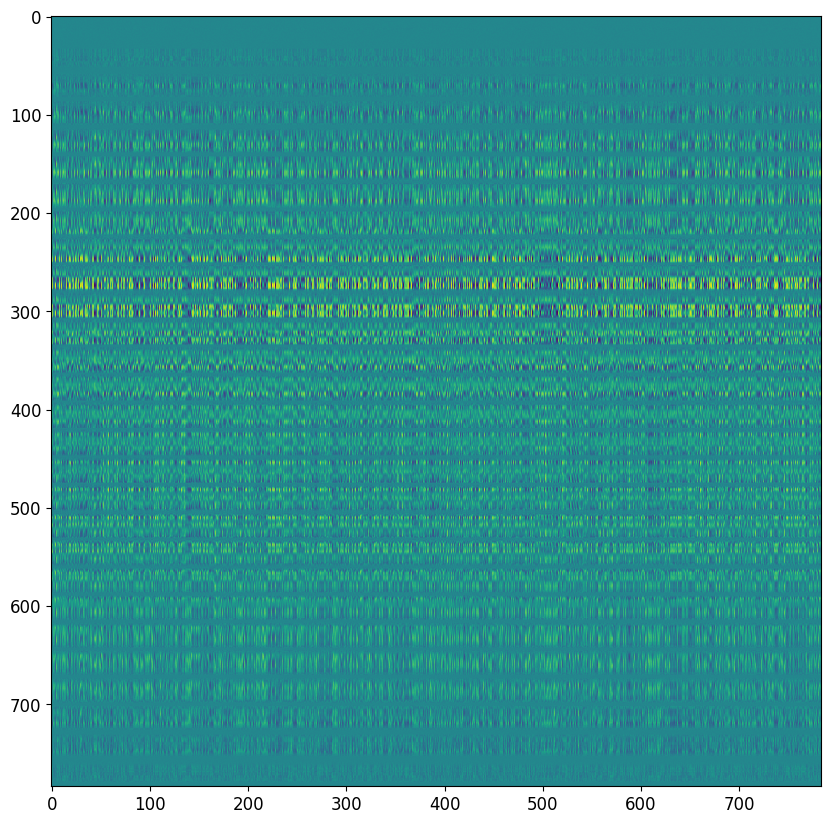

In [25]:
import matplotlib.pyplot as plt

data = base_model.layers[1].get_weights()[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.imshow(data, interpolation='nearest')

In [14]:
def plot_samples(data):
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20, 10))
    ax = ax.flatten()
    for i in range(len(data)):
        img = data[i, :, :]
        #    .numpy().reshape(X.shape[1],X.shape[2],2)
        print()
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    # plt.savefig('./figures/mnist_all.png', dpi=300)
    plt.show()


def plot_conv_img(convolved_image):
    fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20, 10))
    ax = ax.flatten()
    for cv in range(4):
        image = convolved_image[:, :, cv]
        #    .numpy().reshape(X.shape[1],X.shape[2],2)
        ax[cv].imshow(image, cmap='Greys', interpolation='nearest')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    # plt.savefig('./figures/mnist_all.png', dpi=300)
    plt.show()


def plot_conv_imgages(data):
    for i in range(10):  # image
        plot_conv_img(data[i, :, :, :])


In [ ]:
base_model.fit(dataset, epochs=15, callbacks=[early_stopping])
base_model.evaluate(dataset_test)

In [4]:
result = lt.eval_model_opt(
        base_model, X_train, y_train, X_test, y_test, num_epochs=12,
        batch_size=128, optimizer=opti3, callbacks=[early_stopping]
        )


In [11]:
model2 = tf.keras.Sequential(
        [
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
                tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
                tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='he_normal')
                ]
        )
model2.build(input_shape=(None, 28, 28, 1))
opti = tf.keras.optimizers.legacy.SGD(
        learning_rate=0.02, momentum=0.00,
        nesterov=False, name='SGD'
        )
opti2 = tf.keras.optimizers.legacy.Adadelta()
opti3 = tf.keras.optimizers.legacy.Adam()
# base_model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=opti,
#               metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy', min_delta=0.002, patience=2, mode='auto', verbose=True,
        restore_best_weights=True
        )

model2.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=opti,
        metrics=['accuracy']
        )

lt.eval_model(
        model2, X_train, y_train, X_test, y_test,
        epochs=20, batch_size=64, callbacks=[early_stopping]
        )
layer_1_weights = model2.layers[1].get_weights()[0].copy()
layer = model2.layers[1].get_weights()[0]
imgages = [np.reshape(layer[:, i], (28, 28)) for i in range(20)]
plot_samples(imgages, n=20)

models sequential, batch_size = 64
Epoch 1/20
938/938 [==============================] - 3s 4ms/step - loss: 0.9614 - accuracy: 0.6969
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.5045 - accuracy: 0.8554
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4463 - accuracy: 0.8727
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4261 - accuracy: 0.8800
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4260 - accuracy: 0.8799
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.4406 - accuracy: 0.8731
Epoch 6: early stopping
-----
Time: 19.33 seconds
-----
Test loss: 0.413
Test accuracy: 0.884


IndexError: index 10 is out of bounds for axis 1 with size 10

In [7]:
model_logs = result
model_logs['SGD'][0].history
df = join_df_optimizers(model_logs)
print(df)
plot_history(result)

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

rr = pd.DataFrame(model_log.history)
rr.plot(figsize=(16, 10))
plt.grid(True)

In [83]:
opti_sgd = tf.keras.optimizers.SGD(
        learning_rate=0.02, momentum=0.00,
        nesterov=False, name='SGD'
        )
opti_adadelta = tf.keras.optimizers.Adadelta()

result = eval_models_opt(
        base_model, X_train, y_train, X_test, y_test, num_epochs=5,
        batch_size=256, optimizer=[opti_sgd, opti_adadelta]
        )

In [25]:
model_log = result[0][0]
rr1 = pd.DataFrame(model_log.history)

In [85]:
import pandas as pd


def join_df_optimizers(results_model):
    df = pd.DataFrame()
    for opti_name in results_model.keys():
        history = results_model[opti_name][0]
        opti_df, _ = rename_df(pd.DataFrame(history.history), opti_name)
        df.join(opti_df)
    return df


hh = join_df_optimizers(result[0])

In [ ]:
rr1, _ = rename_df(rr1, "sgd")
rr = rr1.join(rr2)

In [27]:
rr.plot(figsize=(16, 10))
plt.grid(True)

In [62]:
rm = result[0]
for k in rm.keys():
    print(rm[k][0].history)


In [20]:

rr1, _ = rename_df(rr1, "xxx")

In [16]:
base_model = tf.keras.Sequential(
        [
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(28 * 28 * 3, activation='relu'),
                tf.keras.layers.Dense(14 * 14 * 3, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax', dtype='float32')
                ]
        )
opti = tf.keras.optimizers.SGD(
        learning_rate=0.01, momentum=0.00,
        nesterov=False, name='SGD'
        )
#opti=tf.keras.optimizers.Adadelta()
base_model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=opti,
        metrics=['accuracy']
        )
evaluate_model(base_model, X_train, y_train, X_test, y_test, num_epochs=12, batch_size=128)

In [ ]:
evaluate_model(base_model, X_train, y_train, X_test, y_test, batch_size=64)

In [13]:
evaluate_model(base_model, X_train, y_train, X_test, y_test, batch_size=256, num_epochs=14)

In [18]:
##model building

m1 = tf.keras.Sequential(
        name="2D-Conv", layers=[
                tf.keras.layers.Conv2D(filters=32, kernel_size=[3, 3], activation='relu', input_shape=(28, 28, 1)),
                #    tf.keras.layers.Conv2D(filters=32,kernel_size=[3,3], activation='relu'),
                #    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                #    tf.keras.layers.Dropout(0.25),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
                ]
        )
es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy', min_delta=0.002, patience=2, mode='auto', verbose=True,
        restore_best_weights=True
        )

result = eval_model_opt(
        m1, X_train, y_train, X_test, y_test, num_epochs=12,
        batch_size=128, optimizer=opti3, callbacks=[es_callback]
        )

In [ ]:
loss = keras.losses.categorical_crossentropy
#loss = keras.losses.sparse_categorical_crossentropy
m1.compile(
        loss=loss,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
        )

In [ ]:
r1v = evaluate_model(m1, X_train, y_train_v, X_test, y_test_v)

In [42]:
m1.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
        )

r1 = evaluate_model(m1, X_train, y_train, X_test, y_test)

In [37]:
##model building
model = keras.Sequential(name="internet_model")
#convolutional layer with rectified linear unit activation
model.add(
        keras.layers.Conv2D(
                32, kernel_size=(3, 3),
                activation='relu',
                input_shape=(28, 28, 1)
                )
        )
#32 convolution filters used each of size 3x3 #again
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3 #choose the best features via pooling
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(keras.layers.Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(keras.layers.Flatten())
#fully connected to get all relevant data
model.add(keras.layers.Dense(128, activation='relu'))
#one more dropout for convergence' sake :)
model.add(keras.layers.Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(
        loss=loss,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
        )
m3 = model
evaluate_model(m3, X_train, y_train_v, X_test, y_test_v)

In [ ]:
result = evaluate_model(m1, X_train, y_train, X_test, y_test, batch_size=128)

In [31]:
#m1.name = "4-32 filters"

m2 = tf.keras.Sequential(
        [
                tf.keras.layers.Conv2D(filters=16, kernel_size=[3, 3], activation='relu', input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=64, kernel_size=[3, 3], activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Dropout(0.25),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
                ]
        )

m2.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=['accuracy']
        )

#m2.name = "16-64 filters"

result = eval_models([m1, m3], X_train, y_train, X_test, y_test, batch_size=128)

In [27]:


result = evaluate_model1(m1, dataset, X_test, y_test, batch_size=128)

In [21]:
import matplotlib.pyplot as plt

model_log = result[0][0]
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(model_log.history['accuracy'])
#plt.plot(model_log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2, 1, 2)
plt.plot(model_log.history['loss'])
#plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [23]:
import pandas as pd

rr = pd.DataFrame(model_log.history)
rr.plot()

In [5]:
mnist = tf.keras.datasets.mnist

#(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = mnist_images / 255.0, mnist_images_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
batch = 128
train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)
        ).shuffle(10000).batch(batch_size=batch)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [6]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10)

    def call(self,
             x
             ):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


# Create an instance of the model
model = MyModel()

In [7]:
eval_model_opt(model, x_train, y_train, x_test, y_test)

In [9]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


@tf.function
def train_step(images,
               labels
               ):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images,
              labels
              ):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [10]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
            f'Epoch {epoch + 1}, '
            f'Loss: {train_loss.result()}, '
            f'Accuracy: {train_accuracy.result() * 100}, '
            f'Test Loss: {test_loss.result()}, '
            f'Test Accuracy: {test_accuracy.result() * 100}'
            )

In [11]:
model.fit(train_ds)

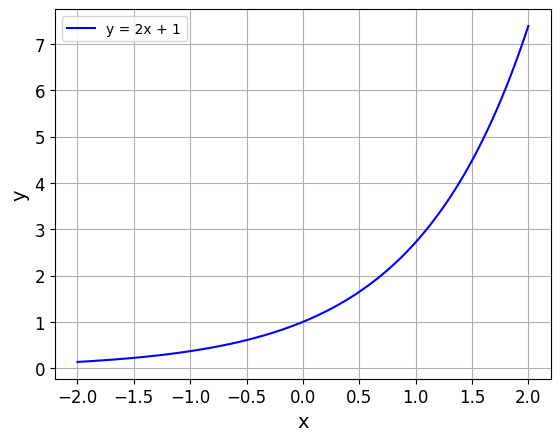

In [221]:
x = np.linspace(-2, 2, 100)  # 100 points from -10 to 10

# Define the function y = 2x + 1
y = np.exp(x)

# Plot the function
plt.plot(x, y, label='y = 2x + 1', color='blue')  # Add label and color
plt.xlabel("x")  # Label for x-axis
plt.ylabel("y")  # Label for y-axis
plt.grid(True)  # Add a grid for better readability
plt.legend()  # Display the legend
plt.show()  # Show the plot

In [23]:
input = keras.Input(shape=(28, 28))
x = keras.layers.Flatten()(input)
x1 = keras.layers.Dense(10, activation='relu')(x)
x2 = keras.layers.Dense(10, activation='relu')(x1)
x3 = x1 + x2
output = keras.layers.Dense(10, activation='softmax')(x3)
model = keras.Model(inputs=input, outputs=output)
model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer="adam",
        metrics=['accuracy']
        )
model.summary()
model.fit(dataset, epochs=5)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 784)       │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 10)        │      7,850 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 10)        │        110 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10)        │          0 │ dense_36[0][0],   │
│                     │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 10)        │        110 │ add_4[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,070 (31.52 KB)

 Trainable params: 8,070 (31.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5258 - loss: 1.4279
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8821 - loss: 0.4193
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8979 - loss: 0.3706
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8992 - loss: 0.3664
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8965 - loss: 0.3736


In [ ]:
model = tf.keras.Sequential(
        [
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal'),
                tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='he_normal')
                ]
        )
base_model.build(input_shape=(None, 28, 28, 1))
opti = tf.keras.optimizers.SGD(
        learning_rate=0.02, momentum=0.00,
        nesterov=False, name='SGD'
        )
opti2 = tf.keras.optimizers.Adadelta()
opti3 = tf.keras.optimizers.Adam()
# base_model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=opti,
#               metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy', min_delta=0.002, patience=2, mode='auto', verbose=True,
        restore_best_weights=True
        )

base_model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=opti,
        metrics=['accuracy']
        )

layer = base_model.layers[1].get_weights()[0]
images = [np.reshape(layer[:, i], (28, 28)) for i in range(20)]
plot_samples(images, n=20)
#base_model.build(input_shape=(None,28,28,1))